In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip -q install timm tqdm


## 데이터셋 구축

train/val 데이터 분할


In [ ]:
# === 설정 ===
from pathlib import Path
import shutil, random

from pathlib import Path
import shutil, random

SRC = Path("/content/drive/MyDrive/gayoung/ba/label_space_data/dataset_trainval")
DST_T = Path("/content/drive/MyDrive/gayoung/ba/label_space_data/dataset_train")
DST_V = Path("/content/drive/MyDrive/gayoung/ba/label_space_data/dataset_val")
    # 출력(val)

TRAIN_RATIO = 0.8
RANDOM_SEED = 42                   # 재현성

# 파일 확장자(필요시 수정)
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
LBL_EXT  = ".txt"                  # YOLO 형식 가정

random.seed(RANDOM_SEED)

def is_hidden(p: Path) -> bool:
    return p.name.startswith(".") or p.name.startswith("._")

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

# 존재하는 서브폴더만 사용(images/labels/preview 중 실제 있는 것만)
SUBS = [d.name for d in SRC.iterdir() if d.is_dir() and d.name in {"images","labels","preview"}]
print("대상 서브폴더:", SUBS)

# 클래스 목록은 images 기준으로 얻음
classes = sorted([d.name for d in (SRC/"images").iterdir() if d.is_dir() and not is_hidden(d)])
print("클래스:", classes)

# 통계
stats = {c: {"train":0, "val":0} for c in classes}
total_train = total_val = 0

for cls in classes:
    img_cls_dir = SRC/"images"/cls
    lbl_cls_dir = SRC/"labels"/cls

    # 이미지 파일 수집(숨김/리소스 파일 제외)
    imgs = [p for p in img_cls_dir.iterdir() if p.is_file() and not is_hidden(p) and p.suffix.lower() in IMG_EXTS]
    # 라벨이 존재하는 이미지만 남김(베이스네임 매칭)
    good = []
    for img in imgs:
        base = img.stem
        lbl  = lbl_cls_dir/(base + LBL_EXT)
        if lbl.exists() and not is_hidden(lbl):
            good.append((img, lbl))

    random.shuffle(good)
    k = int(len(good) * TRAIN_RATIO)
    train_pairs = good[:k]
    val_pairs   = good[k:]

    # 복사 함수
    def copy_pairs(pairs, split_root):
        img_out = split_root/"images"/cls
        lbl_out = split_root/"labels"/cls
        ensure_dir(img_out); ensure_dir(lbl_out)
        for img, lbl in pairs:
            shutil.copy2(img, img_out/img.name)
            shutil.copy2(lbl, lbl_out/lbl.name)
        return len(pairs)

    stats[cls]["train"] = copy_pairs(train_pairs, DST_T)
    stats[cls]["val"]   = copy_pairs(val_pairs,   DST_V)
    total_train += stats[cls]["train"]
    total_val   += stats[cls]["val"]

# preview 폴더가 있으면 동일 비율로 파일만 분할(라벨 없음)
if "preview" in SUBS:
    for cls in sorted([d.name for d in (SRC/"preview").iterdir() if d.is_dir() and not is_hidden(d)]):
        prev_cls_dir = SRC/"preview"/cls
        files = [p for p in prev_cls_dir.iterdir() if p.is_file() and not is_hidden(p)]
        random.shuffle(files)
        k = int(len(files) * TRAIN_RATIO)
        train_f, val_f = files[:k], files[k:]
        for dst_root, lst in [(DST_T, train_f), (DST_V, val_f)]:
            out_dir = dst_root/"preview"/cls
            ensure_dir(out_dir)
            for f in lst:
                shutil.copy2(f, out_dir/f.name)

# 결과 요약 출력
print("\n=== 분할 요약 ===")
for cls in classes:
    print(f"{cls:>20}: train {stats[cls]['train']:4d} | val {stats[cls]['val']:4d}")
print(f"\n총계 → train: {total_train}  /  val: {total_val}")
print("✅ 완료: /content/gayoung/ba/label_space_data/dataset_train & dataset_val")


대상 서브폴더: ['images', 'preview', 'labels']
클래스: ['DANCE_STUDIO', 'MAKER_SPACE', 'MUSIC_PRACTICE_ROOM', 'SMALL_THEATER', 'STUDY_ROOM']

=== 분할 요약 ===
        DANCE_STUDIO: train    8 | val    2
         MAKER_SPACE: train   24 | val    7
 MUSIC_PRACTICE_ROOM: train   30 | val    8
       SMALL_THEATER: train   20 | val    6
          STUDY_ROOM: train   33 | val    9

총계 → train: 115  /  val: 32
✅ 완료: /content/gayoung/ba/label_space_data/dataset_train & dataset_val


**(train/val) Before/After + GT 마스크 생성**


1.  목표: 실제 환경과 유사한 다양한 변화(가림/블러/픽셀화/인페인트/이동)를 자동 적용해, (before, after, mask) 쌍을 일괄 생성
2. 마스크 규칙: 0=배경, 255=변경 영역
3. 활용: 변화 감지(Change Detection), 전/후 비교, 분할(Segmentation) 학습 및 벤치마킹




In [ ]:
import os, json, random, cv2, numpy as np
from pathlib import Path

random.seed(42)

# ====== 경로 설정 ======
BASE = Path("/content/drive/MyDrive/gayoung/ba/label_space_data")
IN_SPLITS = ["dataset_train","dataset_val"]  # 둘 다 처리
OUT = Path("/content/drive/MyDrive/gayoung/ba/pairs_out_cd")   # 결과

# ====== 파라미터 ======
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}
YOLO_LBL_EXT = ".txt"
APPLY_MASK_PROB = 0.85       # 이 확률로 변경 적용(낮추면 '변화 없음' 샘플도 섞임)
MASK_MODE_SET = ["black","inpaint","rect","blur","pixel"]  # 가림 방식 후보
RECT_JITTER = 0.12           # bbox 주변 랜덤 여유
PARTIAL_KEEP_PROB = 0.25     # 변경 영역 일부는 남김(부분 가림)
MIN_BOX_AREA = 20*20         # 너무 작은 박스는 생략
MAX_MOVED_TRIES = 10         # 이동 시도 횟수(경계 밖 방지)

def is_hidden(p: Path): return p.name.startswith(".") or p.name.startswith("._")

def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def read_yolo(txt_path: Path):
    boxes = []
    if not txt_path.exists(): return boxes
    for line in open(txt_path,"r"):
        ps = line.strip().split()
        if len(ps) < 5: continue
        # cls cx cy w h  (normalized)
        cls, cx, cy, w, h = ps[:5]
        try:
            cx, cy, w, h = map(float, (cx, cy, w, h))
            boxes.append((cx,cy,w,h))
        except:
            continue
    return boxes

def yolo_to_xywh(box, W, H):
    cx,cy,w,h = box
    bw, bh = int(w*W), int(h*H)
    x = int((cx - w/2)*W); y = int((cy - h/2)*H)
    x = max(0,x); y = max(0,y)
    x2 = min(W-1, x+bw); y2 = min(H-1, y+bh)
    return x,y, max(2,x2-x), max(2,y2-y)

def jitter_rect(x,y,w,h,W,H,rate):
    jx, jy = int(w*rate), int(h*rate)
    x = max(0, min(W-1, x + random.randint(-jx, jx)))
    y = max(0, min(H-1, y + random.randint(-jy, jy)))
    w = max(2, w + random.randint(-jx, jx))
    h = max(2, h + random.randint(-jy, jy))
    x2 = max(0, min(W-1, x+w)); y2 = max(0, min(H-1, y+h))
    return x, y, x2-x, y2-y

def non_overlapping(new_box, existing, min_iou=0.05):
    # new_box, existing: [x,y,w,h] in pixels
    def iou(a, b):
        ax1,ay1,aw,ah = a; ax2,ay2 = ax1+aw, ay1+ah
        bx1,by1,bw,bh = b; bx2,by2 = bx1+bw, by1+bh
        ix1, iy1 = max(ax1,bx1), max(ay1,by1)
        ix2, iy2 = min(ax2,bx2), min(ay2,by2)
        iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
        inter = iw*ih
        union = aw*ah + bw*bh - inter + 1e-6
        return inter/union
    return all(iou(new_box, b) <= min_iou for b in existing)

def inpaint_rect(img, x,y,w,h):
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.rectangle(mask,(x,y),(x+w,y+h),255,-1)
    return cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

def blur_rect(img, x,y,w,h):
    roi = img[y:y+h, x:x+w]
    if roi.size == 0: return img
    k = max(3, (min(w,h)//10)*2+1)
    img[y:y+h, x:x+w] = cv2.GaussianBlur(roi, (k,k), 0)
    return img

def pixelate_rect(img, x,y,w,h, factor=0.1):
    roi = img[y:y+h, x:x+w]
    if roi.size == 0: return img
    down_w, down_h = max(1,int(w*factor)), max(1,int(h*factor))
    small = cv2.resize(roi,(down_w,down_h), interpolation=cv2.INTER_LINEAR)
    img[y:y+h, x:x+w] = cv2.resize(small,(w,h), interpolation=cv2.INTER_NEAREST)
    return img

def paste_move(img, x,y,w,h, W,H, existing):
    """ 박스를 잘라서 새 위치로 '이동' (라벨용 변경 마스크엔 원위치와 새 위치 모두 반영) """
    src = img[y:y+h, x:x+w].copy()
    tries = 0
    while tries < MAX_MOVED_TRIES:
        nx = random.randint(0, max(0,W-w)); ny = random.randint(0, max(0,H-h))
        cand = [nx,ny,w,h]
        if non_overlapping(cand, existing, min_iou=0.1):
            img[ny:ny+h, nx:nx+w] = src
            # 원 위치는 검정으로 지우기
            img[y:y+h, x:x+w] = 0
            return img, cand
        tries += 1
    return img, None

def apply_change(after, change_mask, box_xywh, W,H):
    """ box를 약간 흔들고, 다양한 방식으로 가림/이동. change_mask에 변경 영역 반영 """
    x,y,w,h = box_xywh
    # 너무 작은 박스는 생략
    if w*h < MIN_BOX_AREA: return after, change_mask, None
    # 살짝 여유/흔들기
    x,y,w,h = jitter_rect(x,y,w,h,W,H, RECT_JITTER)

    mode = random.choice(MASK_MODE_SET + ["move","move"])  # 이동 가중치 조금 높임
    moved_to = None

    if mode == "black":
        cv2.rectangle(after,(x,y),(x+w,y+h),(0,0,0),-1)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode == "rect":
        patch = np.random.randint(0, 30, (h,w,3), dtype=np.uint8)
        after[y:y+h, x:x+w] = patch
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode == "inpaint":
        after[:] = inpaint_rect(after, x,y,w,h)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode == "blur":
        after[:] = blur_rect(after, x,y,w,h)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode == "pixel":
        after[:] = pixelate_rect(after, x,y,w,h, factor=0.15)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode == "move":
        prev = [x,y,w,h]
        after[:], moved_to = paste_move(after, x,y,w,h, W,H, existing=[])
        # 마스크: 원 위치 + 새 위치
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
        if moved_to is not None:
            nx,ny,nw,nh = moved_to
            cv2.rectangle(change_mask,(nx,ny),(nx+nw,ny+nh),255,-1)

    # 변경영역 일부만 남기기(컨투어 단위로 삭제)
    if random.random() < PARTIAL_KEEP_PROB:
        cnts,_ = cv2.findContours(change_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            if cv2.contourArea(c) < MIN_BOX_AREA: continue
            if random.random() < 0.5:
                cv2.drawContours(change_mask, [c], -1, 0, -1)

    return after, change_mask, moved_to

def process_split(split_name: str):
    in_root = BASE / split_name
    img_root = in_root / "images"
    lbl_root = in_root / "labels"

    out_b = OUT / split_name.replace("dataset_","") / "before_images"
    out_a = OUT / split_name.replace("dataset_","") / "after_images"
    out_y = OUT / split_name.replace("dataset_","") / "labels"
    for d in [out_b, out_a, out_y]: ensure_dir(d)

    meta = []
    classes = [d.name for d in img_root.iterdir() if d.is_dir() and not is_hidden(d)]
    total_pairs = 0

    for cls in classes:
        cls_img = img_root/cls
        cls_lbl = lbl_root/cls
        files = [p for p in cls_img.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS and not is_hidden(p)]
        for imgp in files:
            base = imgp.stem
            lblp = cls_lbl/(base + YOLO_LBL_EXT)
            if not lblp.exists():
                # 라벨이 없으면 '변경 없음' 샘플로 만들 수도 있지만 기본은 스킵
                continue

            img = cv2.imread(str(imgp), cv2.IMREAD_COLOR)
            if img is None: continue
            H,W = img.shape[:2]
            boxes = read_yolo(lblp)
            if not boxes:
                # 박스가 없으면 '변경 없음' 샘플로 추가
                after = img.copy()
                change_mask = np.zeros((H,W), np.uint8)
            else:
                after = img.copy()
                change_mask = np.zeros((H,W), np.uint8)
                if random.random() < APPLY_MASK_PROB:
                    # 일부/전부 선택해서 변경
                    chosen = []
                    for b in boxes:
                        x,y,w,h = yolo_to_xywh(b, W,H)
                        chosen.append([x,y,w,h])
                    # 랜덤하게 일부만 변경
                    k = random.randint(1, max(1, len(chosen)))
                    for (x,y,w,h) in random.sample(chosen, k=k):
                        after, change_mask, _ = apply_change(after, change_mask, [x,y,w,h], W,H)
                else:
                    # 변화 없음 샘플
                    pass

            # 파일명 충돌 방지 위해 클래스 접두사
            out_name = f"{cls}__{imgp.name}"
            cv2.imwrite(str(out_b/out_name), img)
            cv2.imwrite(str(out_a/out_name), after)
            cv2.imwrite(str(out_y/(Path(out_name).stem + ".png")), change_mask)

            meta.append({
                "split": split_name.replace("dataset_",""),
                "class": cls,
                "before": str((out_b/out_name).as_posix()),
                "after":  str((out_a/out_name).as_posix()),
                "label":  str((out_y/(Path(out_name).stem + ".png")).as_posix())
            })
            total_pairs += 1

    # 메타 저장
    ensure_dir(OUT/"meta")
    with open(OUT/"meta"/f"pairs_{split_name.replace('dataset_','')}.json","w") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"[{split_name}] 생성 쌍: {total_pairs}")
    return total_pairs

# 실행
ensure_dir(OUT)
tot = 0
for sp in IN_SPLITS:
    tot += process_split(sp)
print(f"[DONE] 총 생성 쌍: {tot}")
print(f"출력 루트: {OUT}")


[dataset_train] 생성 쌍: 115
[dataset_val] 생성 쌍: 32
[DONE] 총 생성 쌍: 147
출력 루트: /content/drive/MyDrive/gayoung/ba/pairs_out_cd


train/val 분할 결과

In [ ]:
import os
def count_files(p):
    return sum(len(files) for _,_,files in os.walk(p))
root = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd"
print("train before:", count_files(f"{root}/train/before_images"))
print("train after :", count_files(f"{root}/train/after_images"))
print("train labels:", count_files(f"{root}/train/labels"))
print("val   before:", count_files(f"{root}/val/before_images"))
print("val   after :", count_files(f"{root}/val/after_images"))
print("val   labels:", count_files(f"{root}/val/labels"))


train before: 115
train after : 115
train labels: 115
val   before: 32
val   after : 32
val   labels: 32


**(train/val) before, aftert, change GT mask 예시**

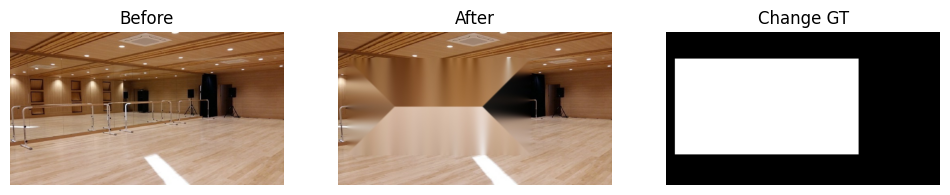

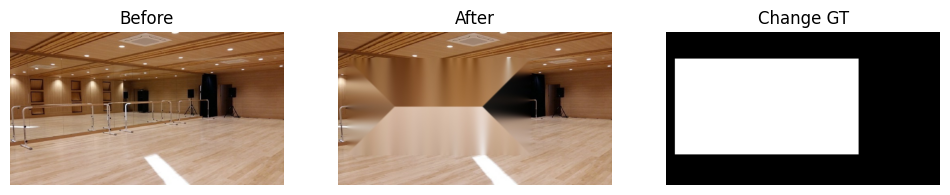

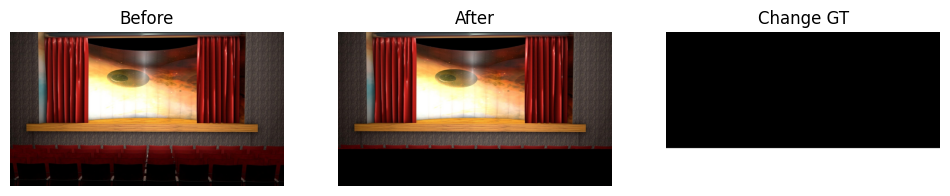

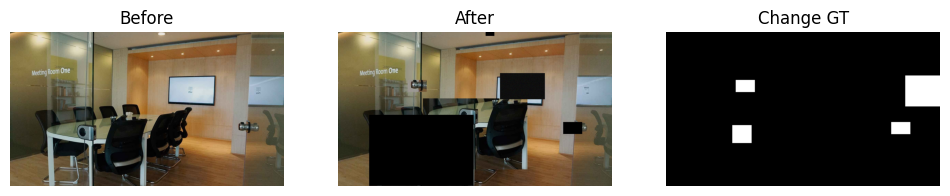

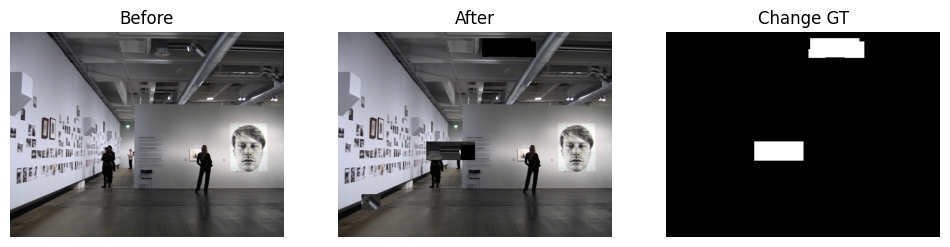

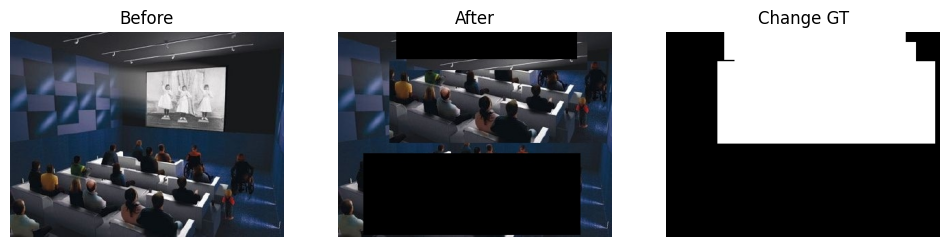

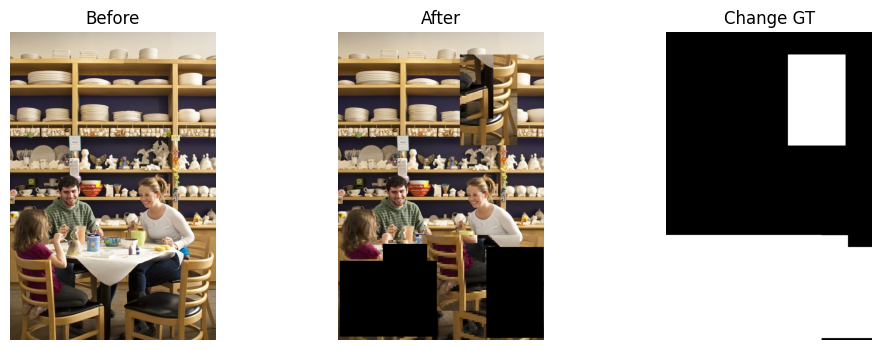

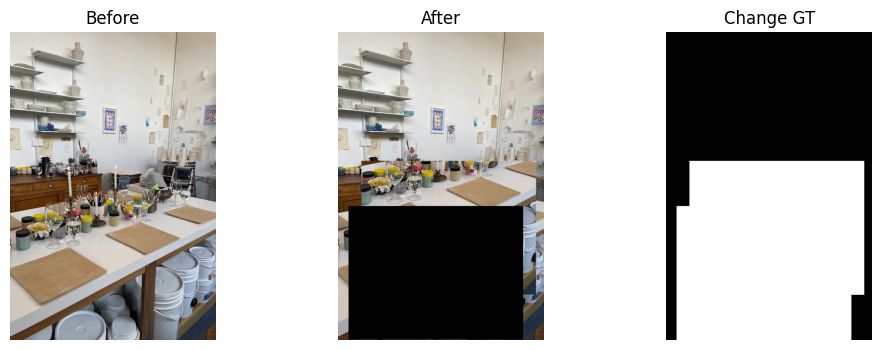

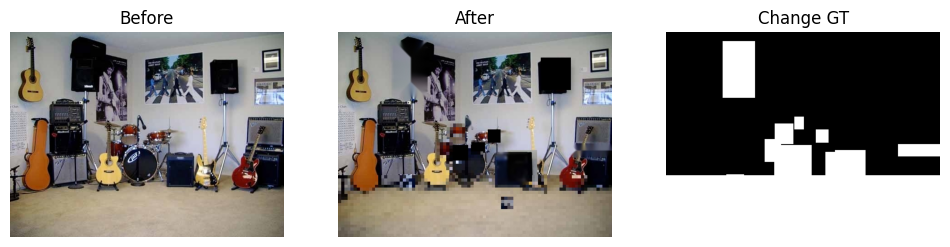

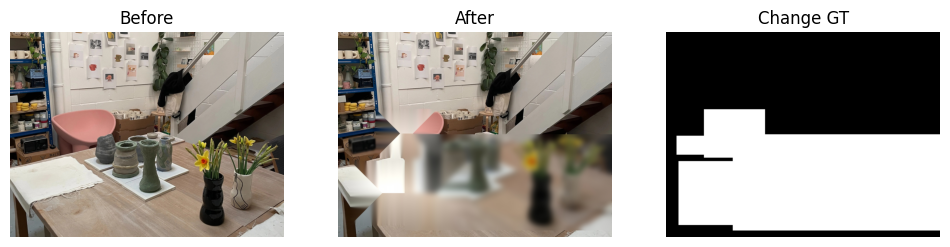

In [ ]:
for _ in range(10):
    show_sample("/content/drive/MyDrive/gayoung/ba/pairs_out_cd","train")


**(test) Before/After + GT 마스크 생성**

In [ ]:
# === TEST 쌍/마스크 생성 ===
import os, json, random, cv2, numpy as np
from pathlib import Path

random.seed(42)

BASE = Path("/content/drive/MyDrive/gayoung/ba/label_space_data")
IN_SPLIT = "dataset_test"   # <-- 테스트 split
OUT = Path("/content/drive/MyDrive/gayoung/ba/pairs_out_cd")

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}
YOLO_LBL_EXT = ".txt"

# 변경 합성 파라미터
APPLY_MASK_PROB = 0.85
MASK_MODE_SET = ["black","inpaint","rect","blur","pixel"]
RECT_JITTER = 0.12
PARTIAL_KEEP_PROB = 0.25
MIN_BOX_AREA = 20*20
MAX_MOVED_TRIES = 10

def is_hidden(p): return p.name.startswith(".") or p.name.startswith("._")
def ensure_dir(p): p.mkdir(parents=True, exist_ok=True)

def read_yolo(txt_path: Path):
    boxes = []
    if not txt_path.exists(): return boxes
    for line in open(txt_path,"r"):
        ps = line.strip().split()
        if len(ps) < 5: continue
        _, cx, cy, w, h = ps[:5]
        try: boxes.append(tuple(map(float,(cx,cy,w,h))))
        except: pass
    return boxes

def yolo_to_xywh(box, W,H):
    cx,cy,w,h = box
    bw, bh = int(w*W), int(h*H)
    x = int((cx - w/2)*W); y = int((cy - h/2)*H)
    x = max(0,x); y = max(0,y)
    x2 = min(W-1, x+bw); y2 = min(H-1, y+bh)
    return x,y, max(2,x2-x), max(2,y2-y)

def jitter_rect(x,y,w,h,W,H,rate):
    jx, jy = int(w*rate), int(h*rate)
    x = max(0, min(W-1, x + random.randint(-jx, jx)))
    y = max(0, min(H-1, y + random.randint(-jy, jy)))
    w = max(2, w + random.randint(-jx, jx))
    h = max(2, h + random.randint(-jy, jy))
    x2 = max(0, min(W-1, x+w)); y2 = max(0, min(H-1, y+h))
    return x, y, x2-x, y2-y

def inpaint_rect(img, x,y,w,h):
    m = np.zeros(img.shape[:2], np.uint8)
    cv2.rectangle(m,(x,y),(x+w,y+h),255,-1)
    return cv2.inpaint(img, m, 3, cv2.INPAINT_TELEA)

def blur_rect(img, x,y,w,h):
    roi = img[y:y+h, x:x+w]
    if roi.size==0: return img
    k = max(3, (min(w,h)//10)*2+1)
    img[y:y+h, x:x+w] = cv2.GaussianBlur(roi,(k,k),0)
    return img

def pixelate_rect(img, x,y,w,h, factor=0.15):
    roi = img[y:y+h, x:x+w]
    if roi.size==0: return img
    dw, dh = max(1,int(w*factor)), max(1,int(h*factor))
    small = cv2.resize(roi,(dw,dh))
    img[y:y+h, x:x+w] = cv2.resize(small,(w,h), interpolation=cv2.INTER_NEAREST)
    return img

def paste_move(img, x,y,w,h, W,H):
    src = img[y:y+h, x:x+w].copy()
    for _ in range(MAX_MOVED_TRIES):
        nx = random.randint(0, max(0,W-w)); ny = random.randint(0, max(0,H-h))
        img[ny:ny+h, nx:nx+w] = src
        img[y:y+h, x:x+w] = 0
        return img, [nx,ny,w,h]
    return img, None

def apply_change(after, change_mask, box_xywh, W,H):
    x,y,w,h = box_xywh
    if w*h < MIN_BOX_AREA: return after, change_mask
    x,y,w,h = jitter_rect(x,y,w,h,W,H, RECT_JITTER)
    mode = random.choice(MASK_MODE_SET + ["move","move"])
    if mode=="black":
        cv2.rectangle(after,(x,y),(x+w,y+h),(0,0,0),-1)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode=="rect":
        patch = np.random.randint(0, 30, (h,w,3), dtype=np.uint8)
        after[y:y+h, x:x+w] = patch
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode=="inpaint":
        after[:] = inpaint_rect(after,x,y,w,h)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode=="blur":
        after[:] = blur_rect(after,x,y,w,h)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode=="pixel":
        after[:] = pixelate_rect(after,x,y,w,h,0.15)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
    elif mode=="move":
        after[:], moved = paste_move(after,x,y,w,h,W,H)
        cv2.rectangle(change_mask,(x,y),(x+w,y+h),255,-1)
        if moved is not None:
            nx,ny,nw,nh = moved
            cv2.rectangle(change_mask,(nx,ny),(nx+nw,ny+nh),255,-1)

    # 일부 컨투어 제거(부분 가림)
    if random.random() < PARTIAL_KEEP_PROB:
        cnts,_ = cv2.findContours(change_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in cnts:
            if cv2.contourArea(c) > MIN_BOX_AREA and random.random()<0.5:
                cv2.drawContours(change_mask,[c],-1,0,-1)
    return after, change_mask

def build_test():
    in_root = BASE/IN_SPLIT
    img_root = in_root/"images"
    lbl_root = in_root/"labels"

    out_b = OUT/"test"/"before_images"
    out_a = OUT/"test"/"after_images"
    out_y = OUT/"test"/"labels"
    for d in [out_b,out_a,out_y]: ensure_dir(d)

    meta = []
    classes = [d.name for d in img_root.iterdir() if d.is_dir() and not is_hidden(d)]
    total = 0

    for cls in classes:
        cls_img = img_root/cls
        cls_lbl = lbl_root/cls
        files = [p for p in cls_img.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS and not is_hidden(p)]
        for imgp in files:
            base = imgp.stem
            lblp = cls_lbl/(base + YOLO_LBL_EXT)
            if not lblp.exists():
                # 라벨 없으면 스킵(원하면 변화 없음 샘플로 추가 가능)
                continue

            img = cv2.imread(str(imgp), cv2.IMREAD_COLOR)
            if img is None: continue
            H,W = img.shape[:2]
            boxes = read_yolo(lblp)

            after = img.copy()
            change_mask = np.zeros((H,W), np.uint8)
            if boxes and random.random() < APPLY_MASK_PROB:
                # 박스 중 일부만 변경
                bxywh = [yolo_to_xywh(b, W,H) for b in boxes]
                k = random.randint(1, max(1,len(bxywh)))
                for (x,y,w,h) in random.sample(bxywh, k=k):
                    after, change_mask = apply_change(after, change_mask, (x,y,w,h), W,H)

            # 저장(클래스 접두사)
            out_name = f"{cls}__{imgp.name}"
            cv2.imwrite(str(out_b/out_name), img)
            cv2.imwrite(str(out_a/out_name), after)
            cv2.imwrite(str(out_y/(Path(out_name).stem + ".png")), change_mask)

            meta.append({
                "split":"test",
                "class":cls,
                "before": str((out_b/out_name).as_posix()),
                "after":  str((out_a/out_name).as_posix()),
                "label":  str((out_y/(Path(out_name).stem + ".png")).as_posix()),
            })
            total += 1

    ensure_dir(OUT/"meta")
    with open(OUT/"meta"/"pairs_test.json","w") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"[dataset_test] 생성 쌍: {total}")
    print(f"출력: {OUT/'test'}")

build_test()


[dataset_test] 생성 쌍: 33
출력: /content/drive/MyDrive/gayoung/ba/pairs_out_cd/test


test 구축 결과

In [ ]:
import os
root = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd/test"
def count(p): return sum(len(fs) for _,_,fs in os.walk(p))
print("test before:", count(f"{root}/before_images"))
print("test after :", count(f"{root}/after_images"))
print("test labels:", count(f"{root}/labels"))


test before: 33
test after : 33
test labels: 33


## 학습

### 데이터셋 로더
1. 목적: (before, after, mask) 쌍을 로드하고 크기/정규화를 일관 적용  
2. 입력: OUT/{train|val}/{before_images, after_images, labels}  
3. 전처리:
- 이미지: [0,1] 정규화, `HWC→CHW`  
- 마스크: **최근접 보간**으로 리사이즈, 0/255→{0,1}  
4. 반환: (before[3×H×W], after[3×H×W], mask[1×H×W])  


In [ ]:
import glob, cv2, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

ROOT_OUT = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd"
IMG_SIZE = (384,384)
BATCH    = 4
EPOCHS   = 40
LR       = 1e-3
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

class PairDataset2In(Dataset):
    def __init__(self, root, split="train", size=(384,384)):
        self.root = Path(root)/split
        self.size = size
        bs = sorted(glob.glob(str(self.root/"before_images/*")))
        A  = {Path(p).name:p for p in glob.glob(str(self.root/"after_images/*"))}
        self.items=[]
        for b in bs:
            nm = Path(b).name
            y  = self.root/"labels"/(Path(nm).stem+".png")
            if nm in A and y.exists():
                self.items.append((b, A[nm], str(y)))
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        pb, pa, py = self.items[i]
        b = cv2.imread(pb)[:,:,::-1]; a = cv2.imread(pa)[:,:,::-1]
        y = cv2.imread(py, cv2.IMREAD_GRAYSCALE)
        if self.size:
            b = cv2.resize(b, self.size, interpolation=cv2.INTER_AREA)
            a = cv2.resize(a, self.size, interpolation=cv2.INTER_AREA)
            y = cv2.resize(y, self.size, interpolation=cv2.INTER_NEAREST)
        b = (b.astype(np.float32)/255.).transpose(2,0,1)
        a = (a.astype(np.float32)/255.).transpose(2,0,1)
        y = (y>0).astype(np.float32)[None,...]
        return torch.from_numpy(b), torch.from_numpy(a), torch.from_numpy(y)


### 모델: TinyChangeUNet
1. **아이디어**: before, after, 그리고 절대차(diff, 1채널)를 합쳐 **7채널** 입력 → 1×1 conv로 3채널 축소 → MobileNetV3(Small) 백본(사전학습) 인코더 → 경량 디코더(TransposeConv + DWConvBlock) → 1채널 로짓 출력
2. **스킵/채널**: 인코더 피처를 24/40/64/96으로 맞춰 디코더와 결합
3. **출력**: 원 해상도로 bilinear 업샘플링된 로짓(시그모이드 전)
4. **장점**: 파라미터 수가 작고 모바일 친화적이며 CD(변화감지) 특화의 `diff` 입력을 사용


In [ ]:
import timm, torch
import torch.nn as nn
import torch.nn.functional as F

class DWConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.dw = nn.Conv2d(c_in, c_in, 3, 1, 1, groups=c_in, bias=False)
        self.bn1= nn.BatchNorm2d(c_in)
        self.pw = nn.Conv2d(c_in, c_out, 1, bias=False)
        self.bn2= nn.BatchNorm2d(c_out)
        self.act= nn.ReLU(inplace=True)
    def forward(self,x):
        x=self.dw(x); x=self.bn1(x); x=self.act(x)
        x=self.pw(x); x=self.bn2(x); x=self.act(x);
        return x

class TinyDecoder(nn.Module):
    def __init__(self, chs):  # [c1,c2,c3,c4]
        super().__init__()
        c1,c2,c3,c4 = chs
        self.up3 = nn.ConvTranspose2d(c4, c3, 2, 2); self.c3=DWConvBlock(c3+c3, c3)
        self.up2 = nn.ConvTranspose2d(c3, c2, 2, 2); self.c2=DWConvBlock(c2+c2, c2)
        self.up1 = nn.ConvTranspose2d(c2, c1, 2, 2); self.c1=DWConvBlock(c1+c1, c1)
    def forward(self, feats):
        f1,f2,f3,f4 = feats
        x = self.up3(f4); x=torch.cat([x,f3],1); x=self.c3(x)
        x = self.up2(x);  x=torch.cat([x,f2],1); x=self.c2(x)
        x = self.up1(x);  x=torch.cat([x,f1],1); x=self.c1(x)
        return x

class MobileNetV3Encoder(nn.Module):
    def __init__(self, out_indices=(0,1,2,3)):
        super().__init__()
        self.backbone = timm.create_model("mobilenetv3_small_100",
                                          pretrained=True, features_only=True,
                                          out_indices=out_indices)
        self.out_channels = self.backbone.feature_info.channels()
    def forward(self,x): return self.backbone(x)

class TinyChangeUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # before(3) + after(3) + diff(1) = 7채널 → 3채널로 투영
        self.reduce = nn.Conv2d(7, 3, 1)
        self.encoder = MobileNetV3Encoder(out_indices=(0,1,2,3))
        c1,c2,c3,c4 = self.encoder.out_channels
        self.skip1 = nn.Conv2d(c1, 24, 1)
        self.skip2 = nn.Conv2d(c2, 40, 1)
        self.skip3 = nn.Conv2d(c3, 64, 1)
        self.bott  = nn.Conv2d(c4, 96, 1)
        self.decoder = TinyDecoder([24,40,64,96])
        self.head = nn.Conv2d(24, 1, 1)

    def forward(self, before, after):
        H, W = before.shape[-2], before.shape[-1]
        diff = torch.mean(torch.abs(before - after), dim=1, keepdim=True)  # N,1,H,W
        x = torch.cat([before, after, diff], dim=1)  # N,7,H,W
        x = self.reduce(x)
        f1,f2,f3,f4 = self.encoder(x)
        f1,f2,f3,f4 = self.skip1(f1), self.skip2(f2), self.skip3(f3), self.bott(f4)
        x = self.decoder([f1,f2,f3,f4])
        logit = self.head(x)
        return F.interpolate(logit, size=(H,W), mode='bilinear', align_corners=False)


### 학습/평가 루프
1. **핵심 기능**  
- **손실**: BCE(with `pos_weight`) + Tversky 혼합(AMP/F16 안전).  
- **클래스 불균형 완화**: train 소배치에서 **positive pixel ratio**를 추정해 `pos_weight` 자동 설정.  
- **스케줄러**: 2 epoch 워밍업 + Cosine Decay.  
- **EMA**: 부동 텐서만 추적, **EMA 가중치**로 검증/저장(안정성↑).  
- **임계값 스윕**: 매 epoch마다 `sweep_streaming`으로 **최적 th**와 (mIoU,F1) 로그.  
- **조기 종료**: 검증 F1 **개선폭 < 0.005**가 12epoch 지속 시 stop.  
- **로깅**: Loss/mIoU/F1 curve 저장(`live_curve.png`).  


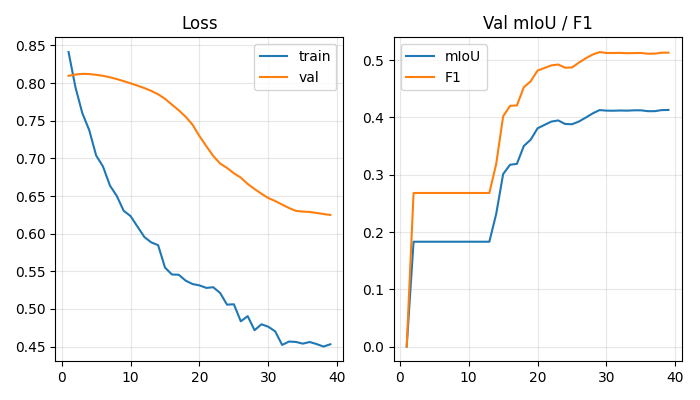

In [ ]:
# ==== imports ====
import os, gc, math, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ==== 하이퍼파라미터 ====
ROOT_OUT = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd"
IMG_SIZE  = 256
BATCH     = 8
EPOCHS    = 40
LR        = 3e-4                 # 손실 안정 위해 한 단계 낮춤 (원하면 1e-3로)
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/content/drive/MyDrive/gayoung/ba/change_tiny_mnv3_best.pth"

USE_POSTPROC = False             # 작은 블랍 제거(평가 시). 필요하면 True

torch.backends.cudnn.benchmark = True

# ------------------------------------------------------------
# 1) 손실 (FP16 안정화) + 디버그 지원
# ------------------------------------------------------------
class BCE_Tversky_FP16_dbg(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, eps=1e-3, pos_weight=None,
                 w_bce=0.6, w_tv=0.4):
        super().__init__()
        self.alpha, self.beta, self.eps = alpha, beta, eps
        self.w_bce, self.w_tv = w_bce, w_tv
        self.register_buffer("pos_weight_buf", None)
        if pos_weight is not None:
            self.pos_weight_buf = torch.as_tensor(pos_weight).reshape(1)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight_buf)

    def forward(self, pred, target, return_parts=False):
        pred = pred.clamp(-15, 15)
        b = self.bce(pred, target)                # BCE
        p = torch.sigmoid(pred)
        tp = (p*target).sum((2,3)).float()
        fp = (p*(1-target)).sum((2,3)).float()
        fn = ((1-p)*target).sum((2,3)).float()
        tv = (tp / (tp + self.alpha*fp + self.beta*fn + self.eps)).mean()
        tv_loss = (1.0 - tv).to(b.dtype)          # Tversky loss
        loss = self.w_bce*b + self.w_tv*tv_loss
        if return_parts:
            return loss, b.detach(), tv_loss.detach()
        return loss

# ------------------------------------------------------------
# 2) 지표 + (옵션) 작은 블랍 제거
# ------------------------------------------------------------
import torch.nn.functional as F
def clean_bin(pm_bin, k=3):
    # pm_bin: [N,1,H,W] 0/1 tensor
    return (F.avg_pool2d(pm_bin, k, 1, k//2) > 0.5).float()

@torch.no_grad()
def compute_metrics_from_sigmoid(pred_sigmoid, gt_bin, th=0.5, postproc=False):
    pm = (pred_sigmoid > th).float()
    if postproc:
        pm = clean_bin(pm, k=3)
    inter = (pm*gt_bin).sum((2,3))
    union = pm.sum((2,3)) + gt_bin.sum((2,3)) - inter + 1e-6
    iou = (inter/union).mean().item()
    f1  = (2*inter/(pm.sum((2,3))+gt_bin.sum((2,3))+1e-6)).mean().item()
    return iou, f1

# ------------------------------------------------------------
# 3) 로그릿 저장 없는 임계값 스윕 (EMA 상태에서 호출)
# ------------------------------------------------------------
def sweep_streaming(model, dl, device, th_grid, postproc=False):
    model.eval()
    t = torch.as_tensor(th_grid, device=device)   # [K]
    K = t.numel()
    inter = torch.zeros(K, device=device)
    union = torch.zeros(K, device=device)
    tp = torch.zeros(K, device=device)
    fp = torch.zeros(K, device=device)
    fn = torch.zeros(K, device=device)

    with torch.no_grad(), torch.amp.autocast('cuda', dtype=torch.float16):
        for b,a,y in dl:
            b,a,y = b.to(device), a.to(device), (y>0.5).to(device).float()
            logit = model(b,a).clamp(-15,15)
            p = torch.sigmoid(logit).float()
            if postproc:
                p = clean_bin((p>0.5).float(), k=3) * 1.0  # 근사 보정,
                p = p.clamp(0,1)                           # th를 다시 적용하므로 0/1 유지
                # 스윕 시엔 확률 기반이 더 낫지만, 후처리 쓰려면 간이근사로 사용

            p2 = p.flatten(2).transpose(1,2)       # [N,HW,1]
            y2 = y.flatten(2).transpose(1,2)
            pm = (p2 > t.view(1,1,-1)).float()     # [N,HW,K]

            pi = (pm*y2).sum(dim=(0,1))
            inter += pi
            u = pm.sum(dim=(0,1)) + y2.sum(dim=(0,1)) - pi
            union += torch.clamp(u, min=1e-6)

            tp += pi
            fp += (pm*(1-y2)).sum(dim=(0,1))
            fn += ((1-pm)*y2).sum(dim=(0,1))

    miou = (inter/union).cpu().numpy()
    f1   = (2*tp/torch.clamp(2*tp+fp+fn, min=1e-6)).cpu().numpy()
    j = int(np.argmax(f1))
    return {"th": float(t[j].item()), "mIoU": float(miou[j]), "F1": float(f1[j])}

# ------------------------------------------------------------
# 4) pos_weight 추정
# ------------------------------------------------------------
@torch.no_grad()
def estimate_pos_weight(dl, device, max_batches=20, clamp_to=10.0):
    pos, tot = 0, 0
    for i, (_, _, y) in enumerate(dl):
        y = (y>0.5).to(device).float()
        pos += y.sum().item()
        tot += y.numel()
        if i+1 >= max_batches: break
    neg = max(tot - pos, 1.0)
    raw = neg / max(pos, 1.0)
    pw  = float(np.sqrt(raw))
    if clamp_to is not None:
        pw = min(pw, clamp_to)
    return pw

# ------------------------------------------------------------
# 5) DataLoader
# ------------------------------------------------------------
tr = PairDataset2In(ROOT_OUT, "train", (IMG_SIZE, IMG_SIZE))
vl = PairDataset2In(ROOT_OUT, "val",   (IMG_SIZE, IMG_SIZE))

dl_tr = DataLoader(tr, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=False, persistent_workers=False)
dl_vl = DataLoader(vl, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=False, persistent_workers=False)

# ------------------------------------------------------------
# 6) 모델/옵티마이저/코사인+워밍업/손실
# ------------------------------------------------------------
model = TinyChangeUNet().to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4, eps=1e-4)

pos_w = estimate_pos_weight(dl_tr, DEVICE, max_batches=20, clamp_to=10.0)
crit  = BCE_Tversky_FP16_dbg(alpha=0.7, beta=0.3, eps=1e-3,
                             w_bce=0.6, w_tv=0.4,
                             pos_weight=torch.tensor([pos_w], device=DEVICE))
print(f"[info] estimated pos_weight ≈ {pos_w:.2f}")

# 코사인 + 워밍업(에폭 기준)
WARMUP_EPOCHS = 2
ETA_MIN = 1e-5
BASE_LR = LR
def set_lr(lr):
    for g in opt.param_groups: g["lr"] = lr
def lr_at_epoch(ep):
    if ep < WARMUP_EPOCHS:
        return BASE_LR * (ep + 1) / max(1, WARMUP_EPOCHS)
    t = ep - WARMUP_EPOCHS
    T = max(1, EPOCHS - WARMUP_EPOCHS)
    return ETA_MIN + 0.5*(BASE_LR - ETA_MIN)*(1 + math.cos(math.pi * t / T))

# ------------------------------------------------------------
# 7) EMA (float 텐서만 추적)
# ------------------------------------------------------------
EMA_DECAY = 0.99
def build_ema(model):
    ema = {}
    for k, v in model.state_dict().items():
        if torch.is_floating_point(v):
            ema[k] = v.detach().clone()
    return ema

@torch.no_grad()
def ema_update(model, ema, decay=EMA_DECAY):
    msd = model.state_dict()
    for k in ema.keys():
        ema[k].mul_((decay)).add_(msd[k], alpha=1-decay)

@torch.no_grad()
def apply_ema_for_eval(model, ema):
    stash = {}
    msd = model.state_dict()
    for k, v in ema.items():
        stash[k] = msd[k].detach().clone()
        msd[k].copy_(v)
    return stash

@torch.no_grad()
def restore_from_stash(model, stash):
    msd = model.state_dict()
    for k, v in stash.items():
        msd[k].copy_(v)

ema = build_ema(model)

# ------------------------------------------------------------
# 8) 학습 루프
# ------------------------------------------------------------
scaler   = torch.amp.GradScaler('cuda')
history  = {"tr":[], "vl":[], "miou":[], "f1":[]}
best_f1  = -1.0
bad      = 0
min_delta = 0.005
patience  = 12
best_th   = 0.5
did_print_val_ratio = False

for ep in range(EPOCHS):
    set_lr(lr_at_epoch(ep))

    # ---- Train ----
    model.train(); run=0; n=0
    pbar = tqdm(dl_tr, desc=f"Epoch {ep+1}/{EPOCHS} [train]")
    for b,a,y in pbar:
        b,a,y = b.to(DEVICE), a.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', dtype=torch.float16):
            logit = model(b,a)
            loss  = crit(logit, y)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        ema_update(model, ema)                # step 후 EMA 갱신
        run += loss.item()*b.size(0); n += b.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=opt.param_groups[0]["lr"])
        del b,a,y,logit,loss
    tr_loss = run/max(1,n)

    # ---- Valid (EMA로 평가 & 저장도 EMA로) ----
    model.eval(); run=0; n=0; ious=[]; f1s=[]
    stash = apply_ema_for_eval(model, ema)  # EMA 적용
    pbar = tqdm(dl_vl, desc=f"Epoch {ep+1}/{EPOCHS} [valid]")
    with torch.no_grad():
        pos_pix, tot_pix = 0, 0
        for b,a,y in pbar:
            b,a,y = b.to(DEVICE), a.to(DEVICE), y.to(DEVICE)
            with torch.amp.autocast('cuda', dtype=torch.float16):
                logit = model(b,a).clamp(-15,15)
                # 파트 로깅 원하면 아래처럼:
                # l, b_part, tv_part = crit(logit, y, return_parts=True)
                # loss = l.item()
                loss = crit(logit, y).item()
                s = torch.sigmoid(logit).float()
                mi, mf = compute_metrics_from_sigmoid(
                    s, (y>0.5).float(), th=best_th, postproc=USE_POSTPROC
                )
            run += loss*b.size(0); n += b.size(0)
            ious.append(mi); f1s.append(mf)
            pbar.set_postfix(loss=f"{loss:.4f}")
            if not did_print_val_ratio:
                pos_pix += (y>0.5).float().sum().item()
                tot_pix += y.numel()
            del b,a,y,logit,s
    if not did_print_val_ratio:
        did_print_val_ratio = True
        print(f"[val] positive pixel ratio ≈ {pos_pix/max(1,tot_pix):.6f}")

    vl_loss = run/max(1,n); miou=float(np.mean(ious)); mf1=float(np.mean(f1s))

    # ---- Save best & Early stop ----
    improved = (mf1 > best_f1 + min_delta)
    if improved:
        best_f1 = mf1; bad = 0
        torch.save(model.state_dict(), SAVE_PATH)   # 현재는 EMA 가중치가 들어가있음
        print("  ↳ best(F1) 갱신, 저장(EMA):", SAVE_PATH)
    else:
        bad += 1
        if bad >= patience:
            print("  ↳ early stop (F1)")
            restore_from_stash(model, stash)
            break

    # ---- 임계값 스윕 (EMA 상태에서 수행) ----
    grid = np.linspace(0.02, 0.40, 40)  # ← 요청한 구간으로 확장
    sweep = sweep_streaming(model, dl_vl, DEVICE, grid, postproc=USE_POSTPROC)
    best_th = sweep["th"]
    print(f"  ↳ [TH SWEEP/EMA] th={best_th:.2f} | mIoU={sweep['mIoU']:.3f} | F1={sweep['F1']:.3f}")

    # EMA 적용 전 가중치 복구
    restore_from_stash(model, stash)

    history["tr"].append(tr_loss); history["vl"].append(vl_loss)
    history["miou"].append(miou);  history["f1"].append(mf1)
    print(f"[{ep:02d}] train {tr_loss:.4f} | val {vl_loss:.4f} | mIoU {miou:.3f} | F1 {mf1:.3f} | th {best_th:.2f}")

    # ---- 메모리 정리 + 라이브 곡선 저장 ----
    torch.cuda.empty_cache(); gc.collect()
    clear_output(wait=True)
    plt.figure(figsize=(7,4))
    xs = np.arange(1, len(history["tr"]) + 1)
    plt.subplot(1,2,1); plt.title("Loss"); plt.plot(xs, history["tr"], label="train"); plt.plot(xs, history["vl"], label="val"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.subplot(1,2,2); plt.title("Val mIoU / F1"); plt.plot(xs, history["miou"], label="mIoU"); plt.plot(xs, history["f1"], label="F1"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("live_curve.png"); plt.close()

print("="*50)
print(f"학습 종료 | 총 Epoch: {len(history['tr'])}")
print(f"최고 F1(EMA): {best_f1:.3f} @ th={best_th:.2f}")
print(f"마지막 Epoch({len(history['tr'])-1})")
print(f"  train loss={history['tr'][-1]:.4f}")
print(f"  val loss  ={history['vl'][-1]:.4f}")
print(f"  mIoU={history['miou'][-1]:.3f}, F1={history['f1'][-1]:.3f}")
print("="*50)


Epoch 40/40 [train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40/40 [valid]:   0%|          | 0/4 [00:00<?, ?it/s]

  ↳ early stop (F1)
학습 종료 | 총 Epoch: 39
최고 F1(EMA): 0.510 @ th=0.36
마지막 Epoch(38)
  train loss=0.4530
  val loss  =0.6248
  mIoU=0.413, F1=0.513


TEST Eval

In [ ]:
# ==== Self-contained TEST Eval (safe after Colab restart) ====
import os, glob, cv2, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# --- 필수 클래스 준비 확인 ---
assert 'TinyChangeUNet' in globals(), "TinyChangeUNet 클래스를 먼저 정의/임포트하세요."
assert 'PairDataset2In' in globals(), "PairDataset2In 클래스를 먼저 정의/임포트하세요."

# --- 공통 설정 (먼저 정의!) ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
AMP_DEVICE = 'cuda' if DEVICE == 'cuda' else 'cpu'
AMP_DTYPE  = torch.float16 if DEVICE == 'cuda' else torch.bfloat16
ROOT_OUT   = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd"
IMG_SIZE   = 256
BATCH      = 8
USE_POSTPROC = False
SAVE_PATH  = "/content/drive/MyDrive/gayoung/ba/change_tiny_mnv3_best.pth"

# --- 유틸 (이 셀에 같이 둠) ---
def clean_bin(pm_bin, k=3):
    return (F.avg_pool2d(pm_bin, k, 1, k//2) > 0.5).float()

@torch.no_grad()
def compute_metrics_from_sigmoid(pred_sigmoid, gt_bin, th=0.5, postproc=False):
    pm = (pred_sigmoid > th).float()
    if postproc:
        pm = clean_bin(pm, k=3)
    inter = (pm*gt_bin).sum((2,3))
    union = pm.sum((2,3)) + gt_bin.sum((2,3)) - inter + 1e-6
    iou = (inter/union).mean().item()
    f1  = (2*inter/(pm.sum((2,3))+gt_bin.sum((2,3))+1e-6)).mean().item()
    return iou, f1

@torch.no_grad()
def sweep_streaming(model, dl, device, th_grid=None, postproc=False):
    import numpy as _np
    if th_grid is None: th_grid = _np.linspace(0.35, 0.65, 13)
    t = torch.as_tensor(th_grid, device=device)   # [K]
    K = t.numel()
    inter = torch.zeros(K, device=device)
    union = torch.zeros(K, device=device)
    tp = torch.zeros(K, device=device)
    fp = torch.zeros(K, device=device)
    fn = torch.zeros(K, device=device)

    with torch.amp.autocast(device_type=AMP_DEVICE, dtype=AMP_DTYPE):
        for b,a,y in dl:
            b,a,y = b.to(device), a.to(device), (y>0.5).to(device).float()
            logit = model(b,a).clamp(-15,15)
            p = torch.sigmoid(logit).float()
            if postproc:
                p = clean_bin((p>0.5).float(), k=3) * 1.0
                p = p.clamp(0,1)

            p2 = p.flatten(2).transpose(1,2)       # [N,HW,1]
            y2 = y.flatten(2).transpose(1,2)
            pm = (p2 > t.view(1,1,-1)).float()     # [N,HW,K]
            pi = (pm*y2).sum(dim=(0,1))
            inter += pi
            u = pm.sum(dim=(0,1)) + y2.sum(dim=(0,1)) - pi
            union += torch.clamp(u, min=1e-6)
            tp += pi
            fp += (pm*(1-y2)).sum(dim=(0,1))
            fn += ((1-pm)*y2).sum(dim=(0,1))

    miou = (inter/union).cpu().numpy()
    f1   = (2*tp/torch.clamp(2*tp+fp+fn, min=1e-6)).cpu().numpy()
    j = int(np.argmax(f1))
    return {"th": float(t[j].item()), "mIoU": float(miou[j]), "F1": float(f1[j])}

# --- 모델 로드 (EMA가 저장된 체크포인트) ---
model = TinyChangeUNet().to(DEVICE).eval()
state = torch.load(SAVE_PATH, map_location=DEVICE)
model.load_state_dict(state, strict=True)

# --- 데이터로더 ---
vl = PairDataset2In(ROOT_OUT, "val",  (IMG_SIZE, IMG_SIZE))
dl_vl = DataLoader(vl, batch_size=BATCH, shuffle=False, num_workers=0)
ts = PairDataset2In(ROOT_OUT, "test", (IMG_SIZE, IMG_SIZE))
dl_ts = DataLoader(ts, batch_size=BATCH, shuffle=False, num_workers=0)

# --- 임계값 스윕 (val) ---
grid = np.linspace(0.02, 0.40, 40)
sweep = sweep_streaming(model, dl_vl, DEVICE, grid, postproc=USE_POSTPROC)
best_th = sweep["th"]
print(f"[VAL SWEEP] th={best_th:.3f} | mIoU={sweep['mIoU']:.3f} | F1={sweep['F1']:.3f}")

# --- 테스트 평가 + PNG 저장 (의존 함수 제거 버전: 연속 번호로 저장) ---
os.makedirs("test_preds", exist_ok=True)

@torch.no_grad()
def eval_and_dump(dl, th):
    ious, f1s = [], []
    global_idx = 0
    for b,a,y in tqdm(dl, desc="TEST"):
        b,a,y = b.to(DEVICE), a.to(DEVICE), (y>0.5).to(DEVICE).float()
        with torch.amp.autocast(device_type=AMP_DEVICE, dtype=AMP_DTYPE):
            logit = model(b,a).clamp(-15,15)
            s = torch.sigmoid(logit).float()

        mi, mf = compute_metrics_from_sigmoid(s, y, th=th, postproc=USE_POSTPROC)
        ious.append(mi); f1s.append(mf)

        pm = (s > th).float()
        if USE_POSTPROC: pm = clean_bin(pm, k=3)
        pm = (pm*255).byte().cpu().numpy()  # [N,1,H,W]

        N = pm.shape[0]
        for j in range(N):
            cv2.imwrite(f"test_preds/{global_idx:05d}.png", pm[j,0])
            global_idx += 1

        del b,a,y,logit,s,pm
    return float(np.mean(ious)), float(np.mean(f1s))

miou_ts, f1_ts = eval_and_dump(dl_ts, best_th)
print("="*60)
print(f"[TEST] mIoU={miou_ts:.3f} | F1={f1_ts:.3f} @ th={best_th:.2f} | postproc={USE_POSTPROC}")
print("pred png → ./test_preds/*.png")


[VAL SWEEP] th=0.361 | mIoU=0.481 | F1=0.650


TEST:   0%|          | 0/5 [00:00<?, ?it/s]

[TEST] mIoU=0.559 | F1=0.638 @ th=0.36 | postproc=False
pred png → ./test_preds/*.png


test 결과 예시 시각화

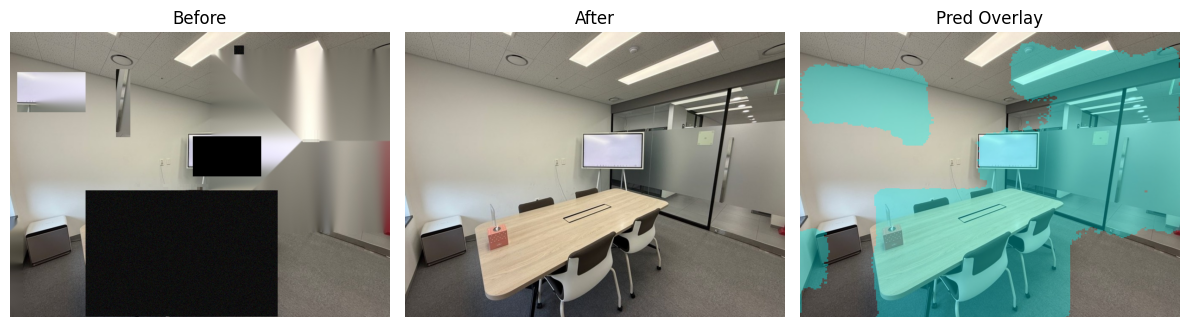

In [ ]:
import cv2, matplotlib.pyplot as plt, numpy as np

# 파일 경로
pb = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd/test/after_images/STUDY_ROOM__Image_4.jpg"
pa = "/content/drive/MyDrive/gayoung/ba/pairs_out_cd/test/before_images/STUDY_ROOM__Image_4.jpg"
pp = "/content/test_preds/00029.png"

# 로드
B  = cv2.imread(pb, cv2.IMREAD_COLOR)[:,:,::-1]
A  = cv2.imread(pa, cv2.IMREAD_COLOR)[:,:,::-1]
PR = cv2.imread(pp, cv2.IMREAD_GRAYSCALE)

# 사이즈 정렬(After 기준)
H,W = A.shape[:2]
if B.shape[:2] != (H,W): B = cv2.resize(B, (W,H), interpolation=cv2.INTER_LINEAR)
if PR.shape[:2]!= (H,W): PR= cv2.resize(PR,(W,H), interpolation=cv2.INTER_NEAREST)

# overlay 함수
def overlay(rgb, mask, color=(0,255,255), alpha=0.35):
    if mask.dtype != np.uint8: mask = mask.astype(np.uint8)
    m = (mask>127).astype("uint8")
    over = (rgb*(1-alpha) + np.array(color,dtype=np.uint8).reshape(1,1,3)*alpha).astype(np.uint8)
    out = rgb.copy(); out[m>0] = over[m>0]
    return out

ov_pred = overlay(A, PR, color=(0,255,255), alpha=0.35)

# 시각화
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(B);       plt.title("Before"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(A);       plt.title("After"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(ov_pred); plt.title("Pred Overlay"); plt.axis("off")
plt.tight_layout()
plt.show()


## CoreML 변환

In [ ]:
import torch

model = TinyChangeUNet().eval().to('cpu')
state = torch.load(SAVE_PATH, map_location='cpu')
model.load_state_dict(state, strict=True)

dummy_b = torch.rand(1,3,256,256)
dummy_a = torch.rand(1,3,256,256)

class Wrapper(torch.nn.Module):
    def __init__(self, net):
        super().__init__(); self.net = net
    def forward(self, before, after):
        logits = self.net(before, after)        # (1,1,H,W)
        return logits

ts = torch.jit.trace(Wrapper(model), (dummy_b, dummy_a))
torch.jit.save(ts, "change_ts.pt")


In [ ]:
!pip install -U "coremltools>=7.2,<8", "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.

CoreML 변환

In [ ]:
# ==== 0) imports ====
import torch, timm
import torch.nn as nn
import torch.nn.functional as F

# ==== 1) encoder  ====
class MobileNetV3Encoder(nn.Module):
    def __init__(self, out_indices=(0,1,2,3), pretrained=False, model_name="mobilenetv3_small_100"):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained,
                                          features_only=True, out_indices=out_indices)
        self.out_channels = self.backbone.feature_info.channels()
    def forward(self, x):
        return self.backbone(x)

# ==== 2) depthwise separable conv ====
class SepConvBN(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.dw  = nn.Conv2d(in_c, in_c, 3, padding=1, groups=in_c, bias=False)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.pw  = nn.Conv2d(in_c, out_c, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
    def forward(self, x):
        x = F.relu(self.bn1(self.dw(x)), inplace=True)
        x = F.relu(self.bn2(self.pw(x)), inplace=True)
        return x

# ==== 3) 디코더 ====
class DecoderCompat(nn.Module):
    def __init__(self):
        super().__init__()
        self.up3 = nn.ConvTranspose2d(96, 64, kernel_size=2, stride=2)  # matches [96,64,2,2]
        self.c3  = SepConvBN(128, 64)                                   # dw:128, pw:64
        self.up2 = nn.ConvTranspose2d(64, 40, kernel_size=2, stride=2)  # [64,40,2,2]
        self.c2  = SepConvBN(80, 40)                                    # dw:80,  pw:40
        self.up1 = nn.ConvTranspose2d(40, 24, kernel_size=2, stride=2)  # [40,24,2,2]
        self.c1  = SepConvBN(48, 24)                                    # dw:48,  pw:24
    def forward(self, s1, s2, s3, b):
        x = self.up3(b);  x = torch.cat([x, s3], dim=1); x = self.c3(x)
        x = self.up2(x);  x = torch.cat([x, s2], dim=1); x = self.c2(x)
        x = self.up1(x);  x = torch.cat([x, s1], dim=1); x = self.c1(x)
        return x

# ==== 4) 전체 네트워크  ====
class TinyChangeUNetV1Compat(nn.Module):
    def __init__(self):
        super().__init__()
        self.reduce  = nn.Conv2d(7, 3, 1)
        self.encoder = MobileNetV3Encoder(out_indices=(0,1,2,3), pretrained=False)
        c1, c2, c3, c4 = self.encoder.out_channels
        # skip을 24/40/64로 투영
        self.skip1 = nn.Conv2d(c1, 24, 1)
        self.skip2 = nn.Conv2d(c2, 40, 1)
        self.skip3 = nn.Conv2d(c3, 64, 1)
        # bottleneck을 96으로 투영 (up3 in_channels=96과 일치)
        self.bott  = nn.Conv2d(c4, 96, 1)
        self.decoder = DecoderCompat()
        self.head    = nn.Conv2d(24, 1, 1)
    def forward(self, before, after):
        diff = (after - before).abs().mean(dim=1, keepdim=True)
        x7   = torch.cat([before, after, diff], dim=1)
        x3   = self.reduce(x7)
        f1, f2, f3, f4 = self.encoder(x3)
        s1, s2, s3, b = self.skip1(f1), self.skip2(f2), self.skip3(f3), self.bott(f4)
        x = self.decoder(s1, s2, s3, b)
        return self.head(x)  # logits

# ==== 5) 내보내기용 래퍼 ====
class WrappedForExport(nn.Module):
    def __init__(self, net, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
        super().__init__(); self.net = net.eval()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std",  torch.tensor(std ).view(1,3,1,1))
    def forward(self, before_u8, after_u8):
        b = (before_u8/255.0 - self.mean) / self.std
        a = (after_u8 /255.0 - self.mean) / self.std
        return self.net(b, a)

# ==== 6) 체크포인트 로드  ====
ckpt = "/content/drive/MyDrive/gayoung/ba/change_tiny_mnv3_best.pth"
net = TinyChangeUNetV1Compat().eval()
state = torch.load(ckpt, map_location="cpu")
net.load_state_dict(state, strict=True)

# ==== 7) TorchScript 저장 ====
H=W=256
wrapped = WrappedForExport(net).eval()
ts = torch.jit.trace(wrapped, (torch.rand(1,3,H,W)*255.0, torch.rand(1,3,H,W)*255.0))
ts.save("change_ts.pt")
print("✔ saved TorchScript -> change_ts.pt")


✔ saved TorchScript -> change_ts.pt


In [ ]:
!pip install -U "coremltools>=7.2,<8" "numpy<2"

import coremltools as ct, torch
ts = torch.jit.load("change_ts.pt", map_location="cpu")
inp_b = ct.ImageType(name="before", shape=(1,3,256,256))
inp_a = ct.ImageType(name="after",  shape=(1,3,256,256))
mlmodel_fp16 = ct.convert(
    ts,
    inputs=[inp_b, inp_a],
    convert_to="mlprogram",
    compute_precision=ct.precision.FLOAT16,
    minimum_deployment_target=ct.target.iOS16,
)

mlmodel_fp16.save("change_unet_fp16.mlpackage")



/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install -U "coremltools>=7.2,<8" "numpy<2"  (설치 후 런타임 재시작)'


Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 157.97 passes/s]


로컬

In [ ]:
# convert_to_mlpackage.py
import torch, torch.nn as nn, torch.nn.functional as F
import coremltools as ct
from pathlib import Path

# === 입력 TS 파일명 ===
TS_FILE = "change_ts.pt"  # 이미 전처리 내장 TS가 있다면 change_ts_with_preproc.pt로 바꿔도 됨

# 1) 원본 TorchScript 로드 (before, after 두 장을 인자로 받는 형태)
ts_core = torch.jit.load(TS_FILE, map_location="cpu").eval()

# 2) 전처리(/255 -> ImageNet mean/std) 래퍼 (항상 /255로, trace 안전)
IMN_MEAN = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
IMN_STD  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)

class PreprocWrapperTS(nn.Module):
    def __init__(self, ts_mod, out_size=None):
        super().__init__()
        self.ts = ts_mod
        self.out_size = out_size

    def _prep(self, x):
        x = x.float() / 255.0
        return (x - IMN_MEAN) / IMN_STD

    def forward(self, before, after):
        b, a = self._prep(before), self._prep(after)
        logits = self.ts(b, a)  # (N,1,H,W) logits
        if self.out_size and logits.shape[-1] != self.out_size:
            logits = F.interpolate(logits, size=(self.out_size, self.out_size),
                                   mode="bilinear", align_corners=False)
        return logits  # 시그모이드 미적용

# 출력 해상도 256
wrapped = PreprocWrapperTS(ts_core, out_size=None).eval()

# 3) TorchScript 재추적
ex_b = torch.zeros(1,3,256,256)
ex_a = torch.zeros(1,3,256,256)
ts_new = torch.jit.trace(wrapped, (ex_b, ex_a))
ts_new.save("change_ts_with_preproc.pt")

# 4) sanity check (0만 나오는지 확인)
with torch.no_grad():
    p = torch.sigmoid(ts_new(ex_b, ex_a))
    print("TS(probs) sanity:", p.min().item(), p.mean().item(), p.max().item(), "|", tuple(p.shape))

# 5) CoreML 변환: FP16, .mlpackage
inp_b = ct.ImageType(name="before", shape=(1,3,256,256))
inp_a = ct.ImageType(name="after",  shape=(1,3,256,256))
mlmodel = ct.convert(
    ts_new,
    inputs=[inp_b, inp_a],
    convert_to="mlprogram",
    minimum_deployment_target=ct.target.iOS16,
    compute_precision=ct.precision.FLOAT16
)
out_path = Path("change_unet_fp16.mlpackage")
mlmodel.save(str(out_path))
print("Saved:", out_path.resolve())
